In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy
from scipy.fft import fft, rfft, fftshift,rfft2
from scipy.special import jv
from matplotlib.image import NonUniformImage

In [25]:
fn = "SN2011fe_MLE_intensity.hdf"
f = h5py.File(fn,'r')
intensity = f['intensity']
f['intensity'].keys()
f['intensity']['axis0']
axis0=intensity['axis0']
axis1=intensity['axis1']
block0_items=intensity['block0_items']
block0_values=intensity['block0_values']
lambdas = numpy.flip(axis1[:])

norm = block0_values[:]
norm = norm/norm[:,1][:,None]
maxs = numpy.max(norm,axis=1)
maxorder = numpy.argsort(maxs)

idx8750 = numpy.abs(lambdas - 8750).argmin()
idx3700 = numpy.abs(lambdas - 3700).argmin()
idx6100 = numpy.abs(lambdas - 6100).argmin()
idx6177 = numpy.abs(lambdas - 6177).argmin()
idx6355 = numpy.abs(lambdas - 6355).argmin()

In [3]:
def dft_polar(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(0,2*numpy.pi*rho*theta)*theta
        ans[i]=numpy.trapezoid(integrand)
    return 2*numpy.pi*ans

def dft_polar_der(y, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    ans = numpy.zeros(norder)
    theta = numpy.arange(ny)
    for i, rho in enumerate(rhos):
        integrand = y*jv(1,2*numpy.pi*rho*theta)*theta**2
        ans[i]=numpy.trapezoid(integrand)
    return -(2*numpy.pi)**2*ans

# for s=1
def dgamma2ds(y,norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    return - 2* gamma * rhos *dft_polar_der(y, norder=norder)

def dgamma2dsi(y, u, vs, norder=None):
    ny = len(y)
    if norder is None:
        norder = ny
    rhos = numpy.arange(norder)/ny
    gamma = dft_polar(y, norder=norder)
    dgammadrho = dft_polar_der(y, norder=norder)
    dum = numpy.sqrt(u**2  + vs**2)
    return 2* numpy.interp(dum, rhos, gamma) * u/dum * numpy.interp(dum, rhos, dgammadrho)

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_76260/4241469245.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(x,(2*jv(1,x)/x)**2,label='Airy')
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_76260/4241469245.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(x,2*(2*jv(1,x)/x)*(jv(0,x)-jv(2,x)-2*jv(1,x)/x),label='dAirydtheta')


(0.0, 10.0)

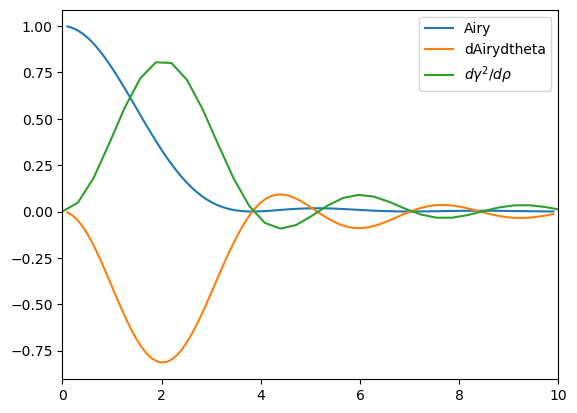

In [4]:
norder = 200
ncirc = 100
factor =20
flux = numpy.zeros(ncirc*factor)
flux[:ncirc]=1
gamma = dft_polar(flux,norder=norder)
gamma20=gamma[0]**2
gamma=gamma/gamma[0]
gamma2 = gamma*gamma
x = numpy.arange(0,10,0.1)
# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma,label=r'$\gamma$')
# plt.plot(x,(2*jv(1,x)/x),label='sqrt Airy')
# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,20*dft_polar_der(flux, norder=norder)/gamma20,label=r'$d\gamma/d\rho$')
# plt.plot((0,12),(0,0))

# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,gamma2,label=r'$\gamma^2$')
plt.plot(x,(2*jv(1,x)/x)**2,label='Airy')
plt.plot(x,2*(2*jv(1,x)/x)*(jv(0,x)-jv(2,x)-2*jv(1,x)/x),label='dAirydtheta')
plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/factor,dgamma2ds(flux, norder=norder)/gamma20,label=r'$d\gamma^2/d\rho$')
# plt.plot((0,12),(0,0))
# plt.ylim((0,10))

# plt.plot(numpy.arange(len(gamma2))*2*numpy.pi/10,numpy.abs(dgamma2ds(flux,norder=norder))/gamma20)

plt.legend()
plt.xlim((0,10))

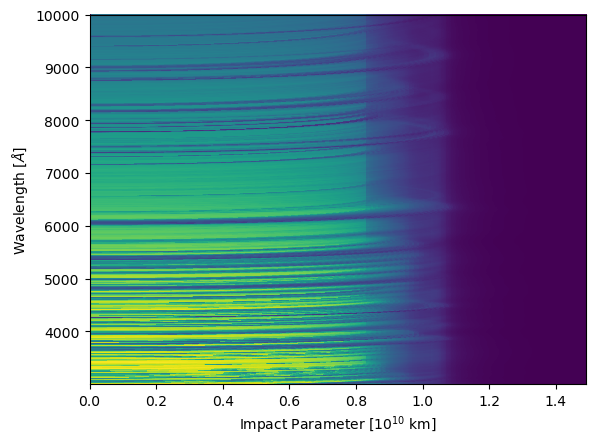

In [5]:
interp = 'nearest'
fig, ax = plt.subplots()
im = NonUniformImage(ax, interpolation=interp, extent=(axis0[0]/1e15,axis0[-1]/1e15,axis1[-1],axis1[0]))
im.set_data(axis0[:]/1e15, lambdas, numpy.flip(block0_values[:,:],axis=0))
ax.add_image(im)
ax.set_xlim(axis0[0]/1e15, axis0[-1]/1e15)
ax.set_ylim(axis1[-1],axis1[0])
ax.set_ylabel(r"Wavelength [$\AA$]")
ax.set_xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.savefig("sn2001fe.pdf")

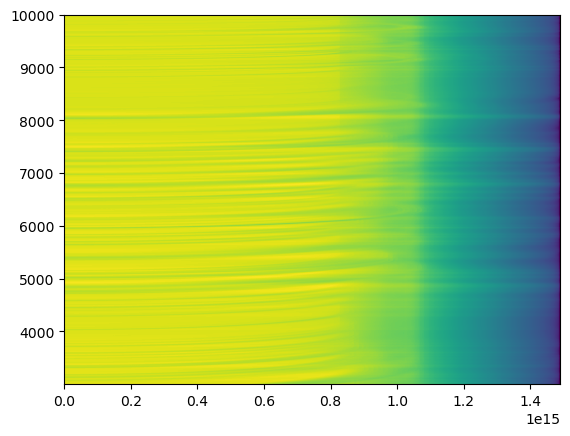

In [6]:
ren = block0_values[:]
ren = ren/ren.sum(axis=1)[:,None]
plt.imshow(ren,extent=[axis0[0],axis0[-1],lambdas[0],lambdas[-1]],aspect='auto',norm='log')

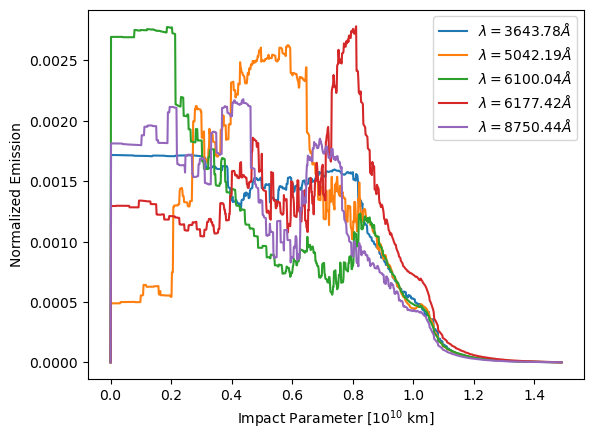

In [26]:
plt.plot(axis0[:]/1e15, ren[maxorder[0],:],label=r"$\lambda={:.2f}\AA$".format(lambdas[maxorder[0]]))
# plt.plot(axis0[:]/1e15, ren[idx3700,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx3700]))
plt.plot(axis0[:]/1e15, ren[maxorder[-1],:],label=r"$\lambda={:.2f}\AA$".format(lambdas[maxorder[-1]]))
plt.plot(axis0[:]/1e15, ren[idx6100,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx6100]))
plt.plot(axis0[:]/1e15, ren[idx6177,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx6177]))

plt.plot(axis0[:]/1e15, ren[idx8750,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx8750]))
plt.xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.ylabel(r"Normalized Emission")
plt.legend()
plt.savefig('impact.pdf')

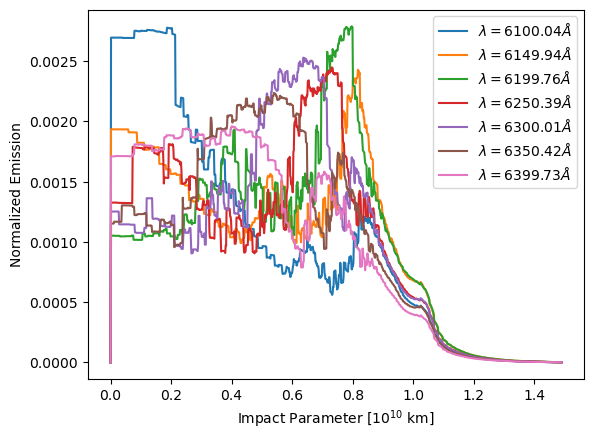

In [23]:
lams = numpy.linspace(6100,6400,7)
idxs = [numpy.abs(lambdas - l).argmin() for l in lams]
for idx in idxs:
    plt.plot(axis0[:]/1e15, ren[idx,:],label=r"$\lambda={:.2f}\AA$".format(lambdas[idx]))

plt.xlabel(r"Impact Parameter [$10^{10}~\text{km}$]")
plt.ylabel(r"Normalized Emission")
plt.legend()

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_76260/2893790344.py:29: RuntimeWarning: invalid value encountered in divide
  airy = (2*jv(1,zeta)/zeta)**2
/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_76260/2893790344.py:36: RuntimeWarning: invalid value encountered in divide
  dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))


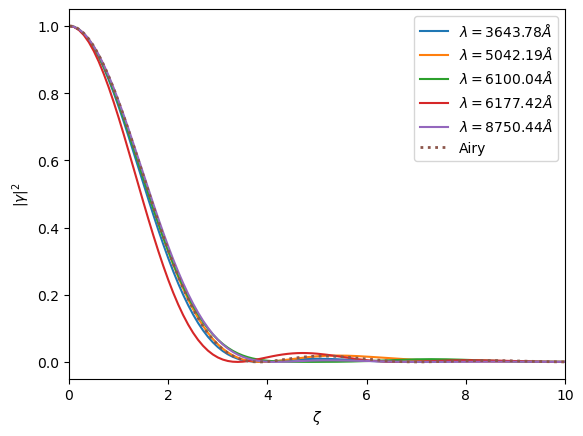

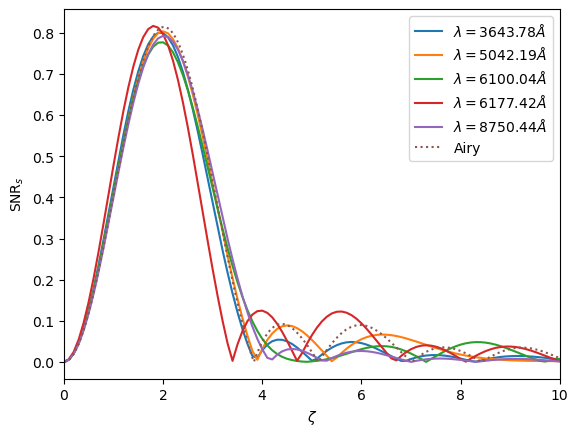

In [27]:
def gamma2snr():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=40
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    # for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
    for index in [maxorder[0],maxorder[-1],idx6100, idx6177, idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
        fm = dgamma2ds(flux, norder=norder)/gamma0**2
        fm= numpy.abs(fm)
        ax2.plot(numpy.arange(fm.shape[0])*2*numpy.pi/(nd*factor/ndisk),fm,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    zeta = numpy.arange(0,nd,0.01)
    airy = (2*jv(1,zeta)/zeta)**2
    ax.plot(zeta,airy,label='Airy',ls='dotted',lw=2)
    ax.set_ylabel(r"$|\gamma|^2$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.legend()
    fig.savefig('gamma2.pdf')
    dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    ax2.plot(zeta,numpy.abs(dairy),label='Airy',ls='dotted')
    ax2.set_ylabel(r"$\text{SNR}_s$")
    ax2.set_xlabel(r"$\zeta$")
    ax2.set_xlim((0,10))
    # ax2.set_ylim((0,1))
    ax2.legend()
    fig2.savefig('snr.pdf')

gamma2snr()

/var/folders/kh/w45qk26j2mj2b95rk71_c0xh0000gn/T/ipykernel_76260/3053306734.py:31: RuntimeWarning: invalid value encountered in divide
  ax.plot(numpy.arange(_.shape[0])*2*numpy.pi/(nd*factor/ndisk),D/_,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))


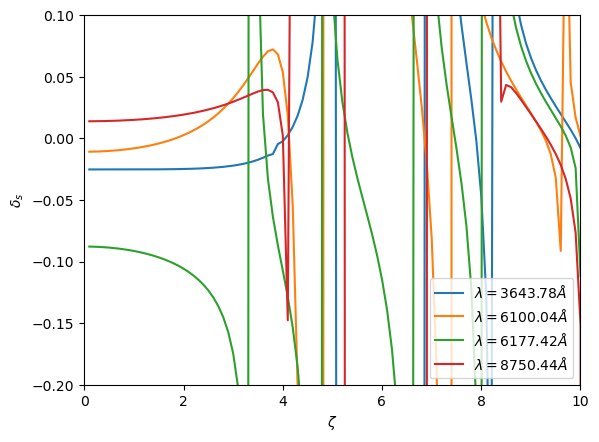

In [29]:
def bias():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=40
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    index = maxorder[-1]#idx6100 #maxorder[0]
    flux[:]=0
    flux[:nd] = block0_values[index,:]
    gamma = dft_polar(flux,norder=norder)
    gamma0 = gamma[0]
    gamma = gamma/gamma0
    gamma2fid = gamma*gamma
    
    # for index in [maxorder[0],idx3700,maxorder[-1],idx6355,idx8750]:
    # for index in [maxorder[0],idx3700,maxorder[-1],idx8750]:
    for index in [maxorder[0],idx6100,idx6177,idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma = gamma/gamma0
        gamma2 = gamma * gamma
        _ = dgamma2ds(flux, norder=norder)/gamma0**2
        D = gamma2-gamma2fid
        ax.plot(numpy.arange(_.shape[0])*2*numpy.pi/(nd*factor/ndisk),D/_,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    ax.set_ylabel(r"$\delta_s$")
    ax.set_xlabel(r"$\zeta$")
    ax.set_xlim((0,10))
    ax.set_ylim((-0.2,0.1))
    ax.legend()
    fig.savefig('bias.pdf')

bias()

In [ ]:
def gamma2snr2():
    nd = axis0[:].shape[0]
    delta = axis0[1]-axis0[0]
    drad = 0.475e15
    ndisk = int(2*drad/delta)
    factor=20
    norder = factor * 5
    
    # nexpand = int(factor*ndisk)
    flux = numpy.zeros(nd*factor)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()  
    for index in [maxorder[0],maxorder[-1],idx6177 ,idx6355,idx8750]:
        flux[:]=0
        flux[:nd] = block0_values[index,:]
        # flux[:ndisk] = 1
        gamma = dft_polar(flux,norder=norder)
        gamma0 = gamma[0]
        gamma=gamma/gamma[0]
        gamma2 = gamma*gamma
        # ax.plot(numpy.arange(gamma2.shape[0])*2*numpy.pi/(nd*factor/ndisk),gamma2,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))

        fm = dgamma2dsi(flux, 1, numpy.arange(20), norder=norder)/gamma0**2
        # fm = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm = numpy.zeros((2,2))
        # dg2ds1 = dgamma2ds1(flux, norder=norder)/gamma0**2
        # fm[0][0] = dgamma2ds(flux, norder=norder)/gamma0**2
        # fm= numpy.abs(fm)
        ax2.plot(numpy.arange(fm.shape[0])*2*numpy.pi/(nd*factor/ndisk),fm,label=r"$\lambda={:.2f}\AA$".format(lambdas[index]))
    
    # zeta = numpy.arange(0,nd,0.01)

    # dairy = (2*(2*jv(1,zeta)/zeta)*(jv(0,zeta)-jv(2,zeta)-2*jv(1,zeta)/zeta))
    # ax2.plot(zeta,numpy.abs(dairy),label='Airy',ls='dotted')
    # ax2.set_ylabel(r"$\text{SNR}_s$")
    # ax2.set_xlabel(r"$\zeta$")
    # ax2.set_xlim((0,10))
    # ax2.set_ylim((0,1))
    ax2.legend()
    fig2.savefig('snr2.pdf')

gamma2snr2()